In [ ]:
# Task
# Prepare the figures with legends, titles interpreting the result
# Table - captions, titles
# Write the methods in past tense

# Look at the accuracy on each of genotypes, confusion matrix, to get the accuracy

#Figure 1: Original Data -> Turn Angle, Distance
#Table 1: Result of binary classification
#Table 2: Result of multi classification


# Require Libraries For Data Processing

In [19]:
import os
import math
from queue import LifoQueue

# Require Libraries For Model Training

In [20]:
import sklearn
import imblearn.over_sampling
import numpy as np

# I. DATA PROCESSING

# 1. Process trajectories data

## Data Description
Time step = 0.033 
The number of row in a file may vary.

| Time | X   | Y |
| --- | --- | --- |
|0.00| -26.98|3.0417|
|0.033|-2.7269|2.995|
|0.066|2.7542|2.995|
|...|...|...|
|598.97|0.2451|-4.3645|

In [21]:
class FileManager:
    
    def __init__(self):
        self.ROOT = "./Trajectories/8.4"
        self.FILE_LOCATION = "XY"
        self.OUTPUT_FOLDER = "./FilterData"
        self.inputPath = ""
        self.outputPath = ""
    
    def setRootPath(self, path):
        self.ROOT = path

    def getFilesFrom(self, flyFolder):
        myPath = os.path.join(self.ROOT, flyFolder, self.FILE_LOCATION)
        #default input path
        self.inputPath = myPath
        #default outputPath
        self.outputPath = os.path.join(self.OUTPUT_FOLDER, flyFolder)
        return os.listdir(myPath)
    
    def makePathFor(self, flyFile):
        myPath = os.path.join(self.inputPath, flyFile)
        return myPath
    
    def makeSavePathFor(self, flyFile):
        myPath = os.path.join(self.outputPath, flyFile)
        return myPath
    
    def saveFile(self, flyFile, data):
        outPath = self.makeSavePathFor(flyFile)
        try:
            with open(outPath,"w") as f:
                for line in data:
                    line_str=[str(i) for i in line]
                    line_csv="\t".join(line_str)
                    f.write(line_csv + "\n")
            print(f'saving to {outPath} complete')
        except Exception as e:
            print(f'Error saving file {outPath}\n')
            print(f'{e}')
            
    def logError(self, error):
        try:
            with open(self.errorPath,"a") as f:
                f.write(error)
        except Exception as e:
            print(f'Error writing log to file {self.errorPath}\n')
            print(f'{e}')

### a. Select genotypes
Genotypes' folders are named after them, so please be aware of not mispelling the name. Programmactically, you can retrieve the name of all folder using `os.listdir(PATH)` but this should be use cautiously if you have extra files in your path.

In [22]:
GENOTYPES = ["cantonS","W1118","norpA7","rutabaga"]

### b. Selecting data from each genotype

For this research, we only choose to use the recorded data with the time interval of 1.0 second. You need to run the code below to extract the data.

In [23]:
totalTime = 10 * 60 # 10 mins * 60 seconds
timeInterval = 1 #second
fileManager = FileManager()

In [24]:
!mkdir $fileManager.OUTPUT_FOLDER
#Create result folders
resultFolder = fileManager.outputPath

for folder in GENOTYPES:
    path = os.path.join(fileManager.OUTPUT_FOLDER, folder)
    !mkdir $path

mkdir: ./FilterData: File exists
mkdir: ./FilterData/cantonS: File exists
mkdir: ./FilterData/W1118: File exists
mkdir: ./FilterData/norpA7: File exists
mkdir: ./FilterData/rutabaga: File exists


* Estimated runtime for the code below - [10 -15] minutes

In [ ]:
#iterrative through each genotype's folders
for genotype in GENOTYPES:
    index = 0
    flyFiles = fileManager.getFilesFrom(genotype)
    
    #iterrative throuch all fly's records in the selected genotype
    for fly in flyFiles:
        try:
            myPath = fileManager.makePathFor(fly)
            with open(myPath, "r") as data:
                print(f'Processing file: {myPath}')
                db = data.readlines()
                #run your function here
                data=[]
                timeline=[]
                for line in db:
                    timeline.append(float(line.strip("\n").split("\t")[0]))
                for i in range(0, totalTime, timeInterval):
                    data.append(db[timeline.index(min(timeline,key=lambda x:abs(x-i)))].strip("\n").split("\t"))
                fileManager.saveFile(fly, data)
                print("")

        except Exception as e:
            print(f'Error processing file {myPath}\n')
            print(f'{e}')

# 2. Convert (x,y) data to (distance, turnangle)

## Location Class
This class is used to calculate distance and turn angle

In [25]:
DISTANCE_THRESHOLD = 0.001

#USE FOR testing 3 points on a line
NOT_ON = 0
SAME_DIRECTION = 1
OPPOSITE_DIRECTION = -1
RATIO_EPSILON = 0.01

class Location:
    def __init__(self, time, x, y):
        self.time = self.convertToFloat(time)
        self.x = self.convertToFloat(x)
        self.y = self.convertToFloat(y)
        self.distance = 0
        self.turnAngle = 0
        
    def convertToFloat(self, number):
        converted = float(number)
        return (0 if math.isnan(converted) else converted)
        
    def print(self):
        print(self.time, self.x, self.y)
    
    def getInfo(self):
        return f'{self.time}\t{self.x}\t{self.y}'
    
    def getDistance(self, b):
        tx = math.pow((self.x - b.x), 2)
        ty = math.pow((self.y - b.y), 2)
        result = math.pow(tx + ty, 0.5)
        
        return result if result > DISTANCE_THRESHOLD else 0
    
    #Find cos(alpha) at t using t - 1 and t + 1
    #return 
    def getCos(self, p1, p3):
        try:
            d1 = self.getDistance(p1)
            d2 = self.getDistance(p3)
            d3 = p1.getDistance(p3)

            #no movement or small changes
            #need to check direction
            
            if (d1 == 0) or (d2 == 0):
                return -1
            #turn angle will be 180degree for coming back to previous location
            if (d3 == 0):
                return 1
            cosAlpha = (d1 * d1 + d2 * d2 - d3 * d3) / (2 * d1 * d2)
        except Exception as e:
            print(f'ERROR: getting cos at times: {p1.time}, {self.time}, {p3.time}')
            
        return cosAlpha
    
    #check to see if they are in a straight line
    #Return: 0: No, 1: same direction, -1: opposite direction
    def onStraightLine(self, p1, p3):
        try:
            #TODO: division by zero check
            X1 = p1.x - self.x
            Y1 = p1.y - self.y
            X2 = p3.x - self.x
            Y2 = p3.y - self.y
            if (X2 == 0) and (X1 != 0):
                return NOT_ON
            if (Y2 == 0) and (Y1 != 0):
                return NOT_ON
            
            if (X2 == 0):
                k1 = Y1 / Y2
                k2 = k1
            elif (Y1 == 0):
                k1 = X1 / X2
                k2 = k1
            else:
                k1 = X1 / X2
                k2 = Y1 / Y2
            d = abs(k1 - k2)
            if d > RATIO_EPSILON:
                return NOT_ON
            else:
                if k1 < 0:
                    return SAME_DIRECTION
                else:
                    return OPPOSITE_DIRECTION
        except Exception as e:
            print(f'ERROR verifying straightline: {e}\n')
            print(f'{p1.getInfo()}\n{self.getInfo()}\n{p3.getInfo()}\n')
            return 0
        
    def calTurnAngleInRadius(self, p1, p3):
        result = 0
        try:
            isOnLine = self.onStraightLine(p1, p3)
            if isOnLine == SAME_DIRECTION:
                result = 0
            elif isOnLine == OPPOSITE_DIRECTION:
                result = math.pi
            else:
                result = math.pi - math.acos(self.getCos(p1, p3))
                
        except Exception as e:
            
            #errorMsg = f'Error calculate turn-angle at:\n {p1.getInfo()}\n{self.getInfo()}\n{p3.getInfo()}\n\n'
            errorMsg = f'{p1.getInfo()}\n{self.getInfo()}\n{p3.getInfo()}\n'
            print(f'ERROR: calculate turn-angle at:{errorMsg}\n')
            print("\n")
            self.logMathError(errorMsg)

            return 0
        
        self.turnAngle = result
        return result
    
    def getTurnAngleInDegree(self):
        return 180 * self.turnAngle / math.pi
    
    def logMathError(self, error):
        errorFile = "./error-math.txt"
        try:
            with open(errorFile,"a") as f:
                f.write(error)
        except Exception as e:
            print(f'Error writing log to file {errorFile}\n')
            print(f'{e}')
        


<table>
    <tr>
        <th>Table 1</th>
        <td>Hee</td>
    </tr>
        <tr>
        <th>Table 2</th>
        <td>Hee</td>
    </tr>
</table>

## LocationManager class  
  * load the files of each genotype from the FilterResult in Section 1.
  * transform the (x,y) coordinate to (distance, turn angle)
  * save all (distance, turn angle) of a genotype into one file

Example: cantonS, 275 files
Each filtered file 
 - Before transform with time interval = 1.0s  

| Time | X   | Y | 
| --- | --- | --- |
|0.00| -26.98|3.0417|
|1|-2.7269|2.995|
|2|2.7542|2.995|
|...|...|...|
|598|...|...|
|599|0.2451|-4.3645|

 - After transforming:
(distance_i, turnangle_i) with i in [0,600)  
NOTE: fly(index) is not included in actual result

| fly(index) | distance_0   | turnangle_0 | ... | ... | distance_599 | turnangle_599|
| --- | --- | --- | --- | --- | --- | --- |
|1| 0|0| ... | ... |0.00571 | 3.14159|
|2| 0|0| ... | ... |0.00306|2.78596|
|3| 0|0| ... | ... |0.00122|2.77905|
|...|...|...||...|...|...|...|
|274| 0|0| ... | ... |0.00928|1.14832|
|275| 0|0| ... | ... |0.01073|3.04171|

In [35]:
#Class for loading and processing (x,y) -> (distance, turnangle)

class LocationManager:
    def __init__(self):
        self.locations = []
        self.errorPath = "./error-log.txt"
        
    #Read file
    def readData(self, fileName):
        store = [] #List of location
        try:
            with open(fileName) as data:
                for line in data.readlines():
                    tmp = line.split()
                    location = Location(tmp[0], tmp[1], tmp[2])
                    store.append(location)
            print(f'Complete reading data for file: {fileName}')
        except Exception as e:
            print(f'ERROR: while reading file: {fileName}')
            print(e)
        return store
    #calculate distance and turn-angle for locations
    def populateLocation(self):
        locationStack = LifoQueue(maxsize = 3) 
        counter = 0
        for location in self.locations:
            if locationStack.empty():
                locationStack.put(location)
            else:
                l1 = locationStack.get()
                location.distance = location.getDistance(l1)
                #if the position does not change, we place the location back in the stack
                if (location.distance <= DISTANCE_THRESHOLD):
                    locationStack.put(location)
                else:
                    # only has two locations, cannot calculate turn angle
                    if locationStack.empty():
                        locationStack.put(l1)
                        locationStack.put(location)
                    else: #has three locations
                        l2 = l1
                        l1 = locationStack.get()
                        l3 = location
                        l2.turnAngle = l2.calTurnAngleInRadius(l1,l3)
                        #add last two locations to stack
                        locationStack.put(l2)
                        locationStack.put(l3)
    #Write file
    def saveResultTo(self, file_path):
        try:
            with open(file_path, "a") as output:
                myData = ""
                for location in self.locations:
                    myData = f'{round(location.distance, 5)}\t\t{round(location.turnAngle, 5)} ' 
                    output.write(myData)
                output.write('\n')
                print(f'Complete saving result to: {file_path}')
        except Exception as e:
            print(f'ERROR: while writing to file {file_path}')
            print(e)
            self.logError(e)
            
    def logError(self, error):
        try:
            with open(self.errorPath,"a") as f:
                f.write(error)
        except Exception as e:
            print(f'ERROR: writing log to file {self.errorPath}\n')
            print(f'{e}')

### Running test cases to validate the calculation

In [27]:
#Integration Testing to validate calculation result
#Create result for testing
manager = LocationManager()
ROOT_TEST = "./TestCases"
fileName = os.path.join(ROOT_TEST, "test-angle-input.txt")
resultFile = os.path.join(ROOT_TEST, "test-angle-output.txt")
validateFile = os.path.join(ROOT_TEST, "test-angle-validate.txt")
manager.locations = manager.readData(fileName)
manager.populateLocation()

Complete reading data for file: ./TestCases/test-angle-input.txt


#### If nothing is displayed after running the line below, the calculation is validated

In [28]:
#Run this to validate turn angle result
!diff $resultFile $validateFile
#if no line or error printed out, the result are match

In [29]:
GENOTYPES = ["cantonS","W1118","norpA7","rutabaga"]

In [44]:
#Create TRANSFORM folders

TRANSFORM_FOLDER = "./Transform"
!mkdir $TRANSFORM_FOLDER

#create folders for each genotypes
for genotype in GENOTYPES:
    path = os.path.join(TRANSFORM_FOLDER, genotype)
    !mkdir $path

* Estimated runtime for the code below - [1 - 2] minutes

In [45]:
locationManager = LocationManager()
input_path = "./FilterData" 
for genotype in GENOTYPES:
    data_path = os.path.join(input_path, genotype)
    flyFiles = os.listdir(data_path)
    result_path = os.path.join(TRANSFORM_FOLDER, genotype, genotype+ "_10min.txt")
    for fly in flyFiles:
        try:
            file_path = os.path.join(data_path, fly)
            print(f'Processing file: {filePath}')
            locationManager.locations = locationManager.readData(file_path)
            print(f'Complete reading file: {file_path}')
            
            print(f'Calculating distance and turn angle')
            locationManager.populateLocation()
            
            locationManager.saveResultTo(result_path)
        except Exception as e:
            print(f'ERROR: processing file {file_path}\n')
            print(f'{e}')

Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run238.txt
Complete reading file: ./FilterData/cantonS/run238.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run204.txt
Complete reading file: ./FilterData/cantonS/run204.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run210.txt
Complete reading file: ./FilterData/cantonS/run210.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.tx

Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run55.txt
Complete reading file: ./FilterData/cantonS/run55.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run41.txt
Complete reading file: ./FilterData/cantonS/run41.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run96.txt
Complete reading file: ./FilterData/cantonS/run96.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Proc

Complete reading data for file: ./FilterData/cantonS/run217.txt
Complete reading file: ./FilterData/cantonS/run217.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run201.txt
Complete reading file: ./FilterData/cantonS/run201.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run215.txt
Complete reading file: ./FilterData/cantonS/run215.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.tx

Complete reading data for file: ./FilterData/cantonS/run266.txt
Complete reading file: ./FilterData/cantonS/run266.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run258.txt
Complete reading file: ./FilterData/cantonS/run258.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run270.txt
Complete reading file: ./FilterData/cantonS/run270.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.tx

Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run276.txt
Complete reading file: ./FilterData/cantonS/run276.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run114.txt
Complete reading file: ./FilterData/cantonS/run114.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run100.txt
Complete reading file: ./FilterData/cantonS/run100.txt
Calculating distance and turn angl

Complete reading data for file: ./FilterData/cantonS/run245.txt
Complete reading file: ./FilterData/cantonS/run245.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run5.txt
Complete reading file: ./FilterData/cantonS/run5.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run127.txt
Complete reading file: ./FilterData/cantonS/run127.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Co

Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run11.txt
Complete reading file: ./FilterData/cantonS/run11.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run39.txt
Complete reading file: ./FilterData/cantonS/run39.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run108.txt
Complete reading file: ./FilterData/cantonS/run108.txt
Calculating distance and turn angle
Co

Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run178.txt
Complete reading file: ./FilterData/cantonS/run178.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run144.txt
Complete reading file: ./FilterData/cantonS/run144.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run150.txt
Complete reading file: ./FilterData/cantonS/run150.txt
Calculating distance and turn angl

Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run197.txt
Complete reading file: ./FilterData/cantonS/run197.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run183.txt
Complete reading file: ./FilterData/cantonS/run183.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/cantonS/cantonS_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/cantonS/run222.txt
Complete reading file: ./FilterData/cantonS/run222.txt
Calculating distance and turn angl

Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run40.txt
Complete reading file: ./FilterData/W1118/run40.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run54.txt
Complete reading file: ./FilterData/W1118/run54.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run68.txt
Complete reading file: ./FilterData/W1118/run68.txt
Calculating distance and turn angle
Complete saving result to: .

Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run104.txt
Complete reading file: ./FilterData/W1118/run104.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run106.txt
Complete reading file: ./FilterData/W1118/run106.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run112.txt
Complete reading file: ./FilterData/W1118/run112.txt
Calculating distance and turn angle
Complete saving result

Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run14.txt
Complete reading file: ./FilterData/W1118/run14.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run119.txt
Complete reading file: ./FilterData/W1118/run119.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run7.txt
Complete reading file: ./FilterData/W1118/run7.txt
Calculating distance and turn angle
Complete saving result to: .

Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run70.txt
Complete reading file: ./FilterData/W1118/run70.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run71.txt
Complete reading file: ./FilterData/W1118/run71.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/W1118/run65.txt
Complete reading file: ./FilterData/W1118/run65.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/W1118/W1118_10min.txt
Processing file: ./FilterDat

Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run50.txt
Complete reading file: ./FilterData/norpA7/run50.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run44.txt
Complete reading file: ./FilterData/norpA7/run44.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run78.txt
Complete reading file: ./FilterData/norpA7/run78.txt
Calculating distance and turn angle
Complete saving 

Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run32.txt
Complete reading file: ./FilterData/norpA7/run32.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run33.txt
Complete reading file: ./FilterData/norpA7/run33.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run27.txt
Complete reading file: ./FilterData/norpA7/run27.txt
Calculating distance and turn angle
Complete saving 

Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run38.txt
Complete reading file: ./FilterData/norpA7/run38.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run10.txt
Complete reading file: ./FilterData/norpA7/run10.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/norpA7/norpA7_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/norpA7/run11.txt
Complete reading file: ./FilterData/norpA7/run11.txt
Calculating distance and turn angle
Complete saving 

Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    19).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    19).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    18).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    18).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
P

Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    15).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    15).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    63).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    63).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular aren

Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    16).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    16).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
Processing file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    50).xls.txt
Complete reading data for file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    29).xls.txt
Complete reading file: ./FilterData/rutabaga/rutabaga in 8_4 circular arena Benjamin-Nov 16, 2011 (Trial    29).xls.txt
Calculating distance and turn angle
Complete saving result to: ./Transform/rutabaga/rutabaga_10min.txt
P

* Verify that we have all the needed files by running the code below
* Your Transform folder should contain folder of each genotype.
* Each genotype's folder should have one file with format <genotype_10min.txt> 

In [53]:
!ls -AR ./Transform/

W1118    cantonS  norpA7   rutabaga

./Transform//W1118:
W1118_10min.txt

./Transform//cantonS:
cantonS_10min.txt

./Transform//norpA7:
norpA7_10min.txt

./Transform//rutabaga:
rutabaga_10min.txt


* Verify that we have 1200 columns for each genotype

In [57]:
NB_COLUMNS = 1200
for genotype in GENOTYPES:
    dataPath = os.path.join(TRANSFORM_FOLDER, genotype, genotype + "_10min.txt")
    with open(dataPath, "r") as inputData:
        line = inputData.readline()
        print(f'{genotype} has {NB_COLUMNS} ? {len(line.split()) == NB_COLUMNS}')

cantonS has 1200 ? True
W1118 has 1200 ? True
norpA7 has 1200 ? True
rutabaga has 1200 ? True


## 3. Partition files  
After converting the recorded data to (distance, turn angle) of 10-minute records, we will split the data into 4 different partitions: first 2.5-minute, first 5-minute, last 5-minute, last 2.5-minute

In [58]:
partitions = [("_first_2.5min", 0, 300), ("_first_5min",0, 600), ("_last_5min",600, 1200), 
              ("_last_2.5min", 900, 1200)]

In [59]:
ROOT = TRANSFORM_FOLDER
fileType = ".txt"

* Estimate runtime for partitioning: 20 seconds

In [60]:
for partition in partitions:
    (partitionName, fromSecond, toSecond) = partition
    for genotype in GENOTYPES:
        #prepare paths for read and write
        inFile = genotype + "_10min" + fileType
        inPath = os.path.join(ROOT, genotype, inFile)
        
        outFile = genotype + partitionName + fileType
        outPath = os.path.join(ROOT, genotype, outFile)
        
        #start reading and writing concurrently
        with open(inPath, "r") as inputData, open(outPath, "w") as output:
            for line in inputData.readlines():
                data = line.split()
                counter = fromSecond
                while counter < toSecond:
                    column = data[counter]
                    output.write(column)
                    output.write(" ")
                    counter += 1
                output.write("\n")

* Verify that we have all the needed files by running the code below
* Your Transform folder should contain folder of each genotype.
* Now, each genotype's folder should have 5 files with their names followed the format <genotype_10min.txt>, <genotype_first_2.5min.txt>, <genotype_first_5min.txt> , <genotype_last_5min.txt> <genotype_last_2.5min.txt>

In [61]:
!ls -AR ./Transform/

W1118    cantonS  norpA7   rutabaga

./Transform//W1118:
W1118_10min.txt        W1118_first_5min.txt   W1118_last_5min.txt
W1118_first_2.5min.txt W1118_last_2.5min.txt

./Transform//cantonS:
cantonS_10min.txt        cantonS_first_5min.txt   cantonS_last_5min.txt
cantonS_first_2.5min.txt cantonS_last_2.5min.txt

./Transform//norpA7:
norpA7_10min.txt        norpA7_first_5min.txt   norpA7_last_5min.txt
norpA7_first_2.5min.txt norpA7_last_2.5min.txt

./Transform//rutabaga:
rutabaga_10min.txt        rutabaga_first_5min.txt   rutabaga_last_5min.txt
rutabaga_first_2.5min.txt rutabaga_last_2.5min.txt


# II. MODEL TRAINING

In this section, we first started training models for binary classfication between wild type `Canton-S` and mutant types `Rutabaga, norpA7, and W1118`. We then trained the models for multi-label classification between each genotype. The machine learning algorithms we chose to experiment with were: `Logistic Regression, Support Vector Machine, Random Forest, and Gradient Boosting`.  

## Set Up

In [62]:
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#helpers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from imblearn.over_sampling import SMOTE
import numpy as np
import os

# Model Selection

We used GridSearchCV to auto train each model with different hyper parameter options to select the best hyper parameters for each model.

In [63]:
def GridLogisticRegression():
    param_grid = param_grid = {
              'penalty': ['l1', 'l2'],  
              'random_state':[0, 42],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'max_iter': [100, 200, 300]
            }
    model = LogisticRegression()
    grid = GridSearchCV(model, param_grid, error_score = np.nan, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridSVC():
    param_grid = param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'rbf']}
    model = SVC()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridRandomForest():
    param_grid = param_grid = {  
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2']}
    model = RandomForestClassifier()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridGradientBoostingClassifier():
    param_grid = param_grid = {  
              'loss': ['deviance', 'exponential'],
              'n_estimators': [500, 1000],
              }
    model = GradientBoostingClassifier()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

# 1. Binary Classification

## Load data for training and testing

* Since our dataset has 5 partitions in total, we used variable `partition_index` to load the training partition that we want to use.
* We labeled `0` for the mutant types and `1` for the non-mutant type

In [67]:
DATA_PATH = "./Transform"
PARTITIONS = ["_first_2.5min.txt", "_first_5min.txt", "_last_5min.txt", "_last2.5min.txt", "_10min.txt"]

In [68]:
labels = {0: ["W1118","norpA7","rutabaga"], 1: ["cantonS"]}
X0 = np.array(0)
y = np.array(0)

#change file index to load corresponding data 
partition_index = 0

#reading data accoding to label
for label in labels.keys():
    genotypes = labels[label]
    labelSize = 0
    for genotype in genotypes:
        fileName = genotype + PARTITIONS[partition_index]
        inFile = os.path.join(DATA_PATH, genotype, fileName)
        data = np.loadtxt(inFile)
        if X0.size == 1: # loading data the first time
            X0 = data
        else:
            X0 = np.concatenate((X0, data))
        labelSize += len(data)
        
    #create y value for corresponding label
    labelValues = np.zeros((1, labelSize)) + label
    if y.size == 1:
        y = labelValues
    else:
        y = np.concatenate((y, labelValues), axis = 1)

* We then split the dataset into training and testing with ration 80:20

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X0, y.T, test_size = 0.20, random_state=101)

* We then used StandarScaler to normalize both training and testing data

In [70]:
scaler = StandardScaler()
#Training data

scaled_data = scaler.fit_transform(X_train)
X_train_processed = scaled_data

#Testing data
scaled_data = scaler.transform(X_test)
X_test_processed = scaled_data

## a. Training with Logistic Regression

### Training

In [71]:
grid = GridLogisticRegression()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.67608696        nan        nan
        nan 0.67391304 0.6673913  0.6673913  0.67391304 0.68913043
 0.6673913  0.6673913  0.68043478 0.68695652        nan        nan
        nan 0.67391304        nan        nan        nan 0.67391304
 0.6673913  0.6673913  0.66521739 0.67173913 0.6673913  0.6673913
 0.66304348 0.67608696        nan        nan        nan 0.67608696
        nan        nan        nan 0.67608696 0.6673913  0.6673913
 0.66956522 0.6673913  0.6673913  0.6673913  0.6673913  0.6673913 ]
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'random_state': [0, 42],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             verbose=3)

### Testing

In [72]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59        72
         1.0       0.41      0.52      0.46        44

    accuracy                           0.53       116
   macro avg       0.53      0.53      0.53       116
weighted avg       0.56      0.53      0.54       116



### Get the hyper parameters

In [74]:
grid.best_params_

{'max_iter': 100, 'penalty': 'l2', 'random_state': 0, 'solver': 'saga'}

## b. Training with Random Forest

### Training

In [76]:
grid = GridRandomForest()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

### Testing

In [72]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59        72
         1.0       0.41      0.52      0.46        44

    accuracy                           0.53       116
   macro avg       0.53      0.53      0.53       116
weighted avg       0.56      0.53      0.54       116



### Get the hyper parameters

In [81]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

## c. Training with Support Vector Machine

### Training

In [77]:
grid = GridSVC()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

### Testing

In [78]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.79      0.69      0.74        72
         1.0       0.58      0.70      0.64        44

    accuracy                           0.70       116
   macro avg       0.69      0.70      0.69       116
weighted avg       0.71      0.70      0.70       116



### Get the hyper parameters

In [79]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

## d. Training with Gradient Boosting

### Training

In [82]:
grid = GridGradientBoostingClassifier()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['deviance', 'exponential'],
                         'n_estimators': [500, 1000]},
             verbose=3)

### Testing

In [83]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81        72
         1.0       0.68      0.77      0.72        44

    accuracy                           0.78       116
   macro avg       0.76      0.78      0.77       116
weighted avg       0.78      0.78      0.78       116



### Get the hyper parameters

In [84]:
grid.best_params_

{'loss': 'deviance', 'n_estimators': 1000}

# 2. Multi-label Classification

## Load data for training and testing

* Since our dataset has 5 partitions in total, we used variable `partition_index` to load the training partition that we want to use.
* We labeled `0`: cantonS, `1`: W118, `2`: norpA7, `3`: rutabaga.
* Since the data between each class was not balanced, we used SMOTE to perform over sampling for low data classes.
* We used confusion matrix to measure the performance of each trained model.

In [95]:
DATA_PATH = "./Transform"
PARTITIONS = ["_first_2.5min.txt", "_first_5min.txt", "_last_5min.txt", "_last2.5min.txt", "_10min.txt"]

In [96]:
labels = {0: ["cantonS"], 1: ["W1118"],2:["norpA7"],3:["rutabaga"]}
X0 = np.array(0)
y = np.array(0)

#change file index to load corresponding data 
partition_index = 0

#reading data accoding to label
for label in labels.keys():
    genotypes = labels[label]
    labelSize = 0
    for genotype in genotypes:
        fileName = genotype + PARTITIONS[partition_index]
        inFile = os.path.join(DATA_PATH, genotype, fileName)
        data = np.loadtxt(inFile)
        if X0.size == 1: # loading data the first time
            X0 = data
        else:
            X0 = np.concatenate((X0, data))
        labelSize += len(data)
        
    #create y value for corresponding label
    labelValues = np.zeros((1, labelSize)) + label
    if y.size == 1:
        y = labelValues
    else:
        y = np.concatenate((y, labelValues), axis = 1)

* We then split the dataset into training and testing with ration 80:20

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X0, y.T, test_size = 0.20, random_state=101)

* We then perform SMOTE in the train dataset to balance it

In [98]:
#Balance the training set
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

* We then used StandarScaler to normalize both training and testing data

In [99]:
scaler = StandardScaler()
#Training data

scaled_data = scaler.fit_transform(X_train)
X_train_processed = scaled_data

#Testing data
scaled_data = scaler.transform(X_test)
X_test_processed = scaled_data

## Prepare metric method

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [101]:
def measurePerformanceWithConfusionMatrix(model, X_test, y_test, labels):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=labels,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()

## a. Training with Logistic Regression

### Training

In [102]:
grid = GridLogisticRegression()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.80222598        nan        nan
        nan 0.80222598 0.81170752 0.81170752 0.79867568 0.79512539
 0.81170752 0.81170752 0.79630882 0.79630882        nan        nan
        nan 0.80222598        nan        nan        nan 0.80222598
 0.81170752 0.81170752 0.80222598 0.79749225 0.81170752 0.81170752
 0.80222598 0.79749225        nan        nan        nan 0.80340237
        nan        nan        nan 0.80340237 0.81170752 0.81170752
 0.80341646 0.80104255 0.81170752 0.81170752 0.80341646 0.80104255]
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'random_state': [0, 42],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             verbose=3)

### Testing

In [103]:
labels =["cantonS", "W1118", "norpA7", "rutabaga"]

Confusion matrix, without normalization
[[40  7 11  6]
 [11  8  2  4]
 [ 6  3  7  2]
 [ 6  1  0  2]]
Normalized confusion matrix
[[0.625      0.109375   0.171875   0.09375   ]
 [0.44       0.32       0.08       0.16      ]
 [0.33333333 0.16666667 0.38888889 0.11111111]
 [0.66666667 0.11111111 0.         0.22222222]]


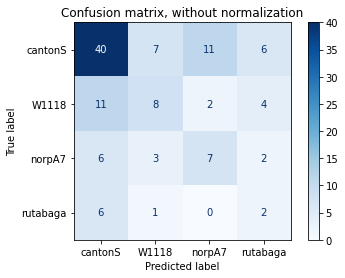

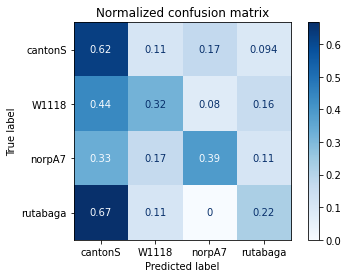

In [104]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [105]:
grid.best_params_

{'max_iter': 100, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg'}

## b. Training with Random Forest

### Training

In [106]:
grid = GridRandomForest()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[48  8  4  4]
 [ 5 12  7  1]
 [ 6  1 10  1]
 [ 6  0  0  3]]
Normalized confusion matrix
[[0.75       0.125      0.0625     0.0625    ]
 [0.2        0.48       0.28       0.04      ]
 [0.33333333 0.05555556 0.55555556 0.05555556]
 [0.66666667 0.         0.         0.33333333]]


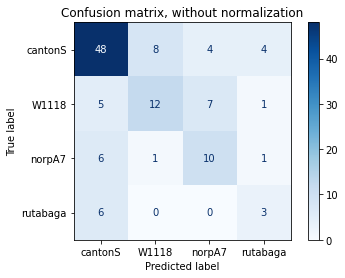

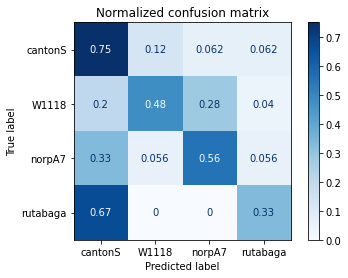

In [107]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [108]:
grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto'}

## c. Training with Support Vector Machine

### Training

In [109]:
grid = GridSVC()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[56  4  4  0]
 [10  7  8  0]
 [ 9  1  8  0]
 [ 6  1  1  1]]
Normalized confusion matrix
[[0.875      0.0625     0.0625     0.        ]
 [0.4        0.28       0.32       0.        ]
 [0.5        0.05555556 0.44444444 0.        ]
 [0.66666667 0.11111111 0.11111111 0.11111111]]


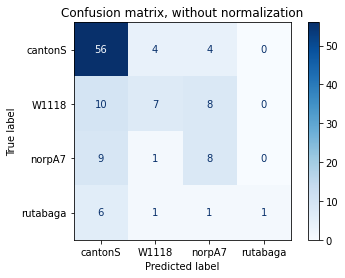

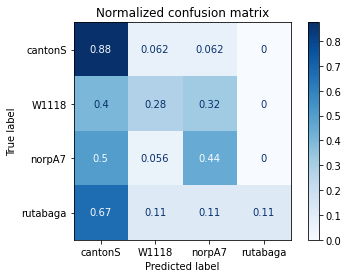

In [110]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [111]:
grid.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

## d. Training with Gradient Boosting

### Training

In [112]:
grid = GridGradientBoostingClassifier()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.86262327 0.86381375        nan        nan]
  warnings.warn(


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['deviance', 'exponential'],
                         'n_estimators': [500, 1000]},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[54  4  4  2]
 [ 7  9  8  1]
 [ 6  1 10  1]
 [ 4  0  0  5]]
Normalized confusion matrix
[[0.84375    0.0625     0.0625     0.03125   ]
 [0.28       0.36       0.32       0.04      ]
 [0.33333333 0.05555556 0.55555556 0.05555556]
 [0.44444444 0.         0.         0.55555556]]


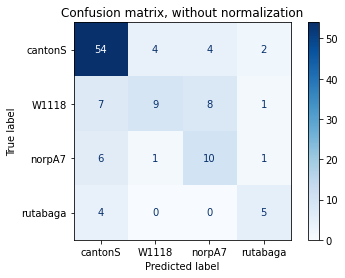

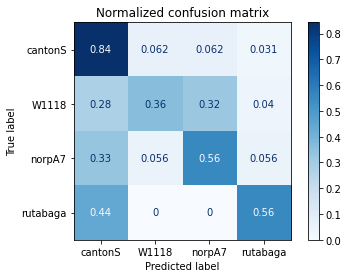

In [113]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [114]:
grid.best_params_

{'loss': 'deviance', 'n_estimators': 1000}